# Diamonds Price Prediction

### Features:
1. __price__ price in US dollars (\$326--\$18,823)

2. __carat__ weight of the diamond (0.2--5.01)

3. __cut__ quality of the cut (Fair, Good, Very Good, Premium, Ideal)

4. __color__ diamond colour, from J (worst) to D (best)

4. __clarity__ a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

5. __x__ length in mm (0--10.74)

6. __y__ width in mm (0--58.9)

7. __z__ depth in mm (0--31.8)

8. __depth__ total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

10. __table__ width of top of diamond relative to widest point (43--95)

### Importing all the required libraries

In [2]:
# importing tabular data and matrices handlers
import numpy as np
import pandas as pd

# importing modeling helpers
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, cross_val_score

# importing preprocessing helpers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from sklearn.model_selection import train_test_split

# importing regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

# importing evaluating metrics
from sklearn.metrics import mean_squared_error, r2_score

# importing time keeper
import time

# importing pipelining helpers
from sklearn.pipeline import Pipeline

# importing visualization packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# configuring visualizations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [15, 7]
}
plt.rcParams.update(params)


# ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Data Accessing

In [3]:
# reading the dataset in a dataframe
df_diamonds = pd.read_csv("train.csv")

## Data Info

In [5]:
# viewing first five rows of the dataset
df_diamonds.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [6]:
# viewing the shape of the dataset
df_diamonds.shape

(43152, 11)

In [7]:
df_diamonds.drop("Id",axis=1,inplace=True)

In [8]:
# viewing the high level information of the dataset
df_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43152 non-null  float64
 8   y        43152 non-null  float64
 9   z        43152 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [9]:
# checking null values in the dataset
df_diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

**There are no null values present in the dataset**

In [10]:
df_diamonds.duplicated().sum()

97

No duplicated rows

In [11]:
# viewing summary statistics
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


 the statistical data, it can be observed that the minimum values in the dimensions(x,y,z) columns is 0. Since x, y, and z represent length, width, and height respectively, it's impossible for a diamond to have a zero dimension. This is faulty data.

In [12]:
# viewing summary statistics
df_diamonds.describe(include = 'object')

,cut,color,clarity
count,43152,43152,43152
unique,5,7,8
top,Ideal,G,SI1
freq,17203,9060,10428


In [13]:
# viewing the statistical data of the features in the dataset
df_diamonds.describe(include='all')

,carat,cut,color,clarity,depth,table,price,x,y,z
count,43152.000000,43152,43152,43152,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
unique,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,17203,9060,10428,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.797855,NaN,NaN,NaN,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,0.473594,NaN,NaN,NaN,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,NaN,NaN,NaN,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,NaN,NaN,NaN,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000


# EDA

### Viewing correlation matrix and histograms

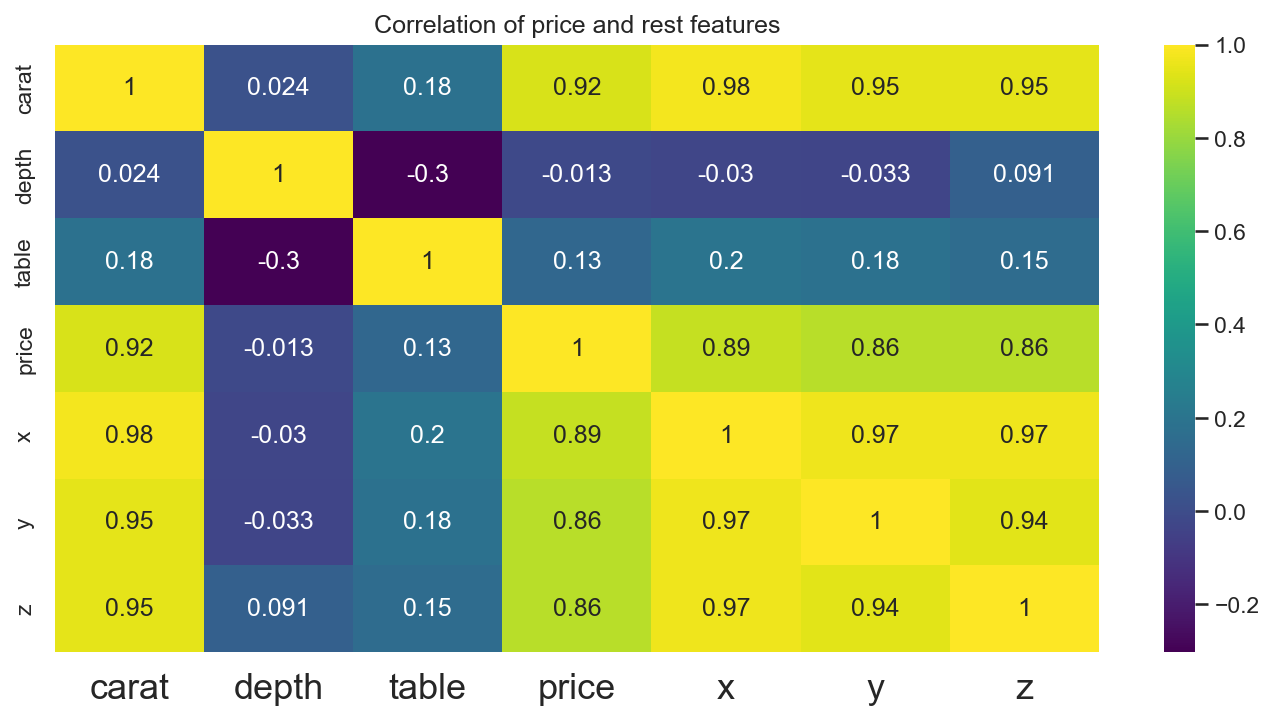

In [14]:

numeric_train_data = df_diamonds.select_dtypes(include=['number'])
plt.figure(figsize=(10, 5))
sns.heatmap(numeric_train_data.corr(), annot=True, cmap='viridis')
plt.title("Correlation of price and rest features")
plt.show()

**From the correlation matrix, following can be observed:**

1. The price of the diamond is highly correlated with the carat and the dimensions (x,y,z). Since the intention is to perform multivariate regression, "carat" won't be considered for predicting the price of the diamond. Hence, the dimensions of the diamond would have the most significant impact on its price.
2. The carat of the diamond is highly correlated with the price and the dimensions (x,y,z). Since the intention is to perform multivariate regression, "price" won't be considered for predicting the carat of the diamond. Hence, the dimensions of the diamond would have the most significant impact on its carat.
3. Price and the Carat of the diamond are not correlated with its depth and table.

array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

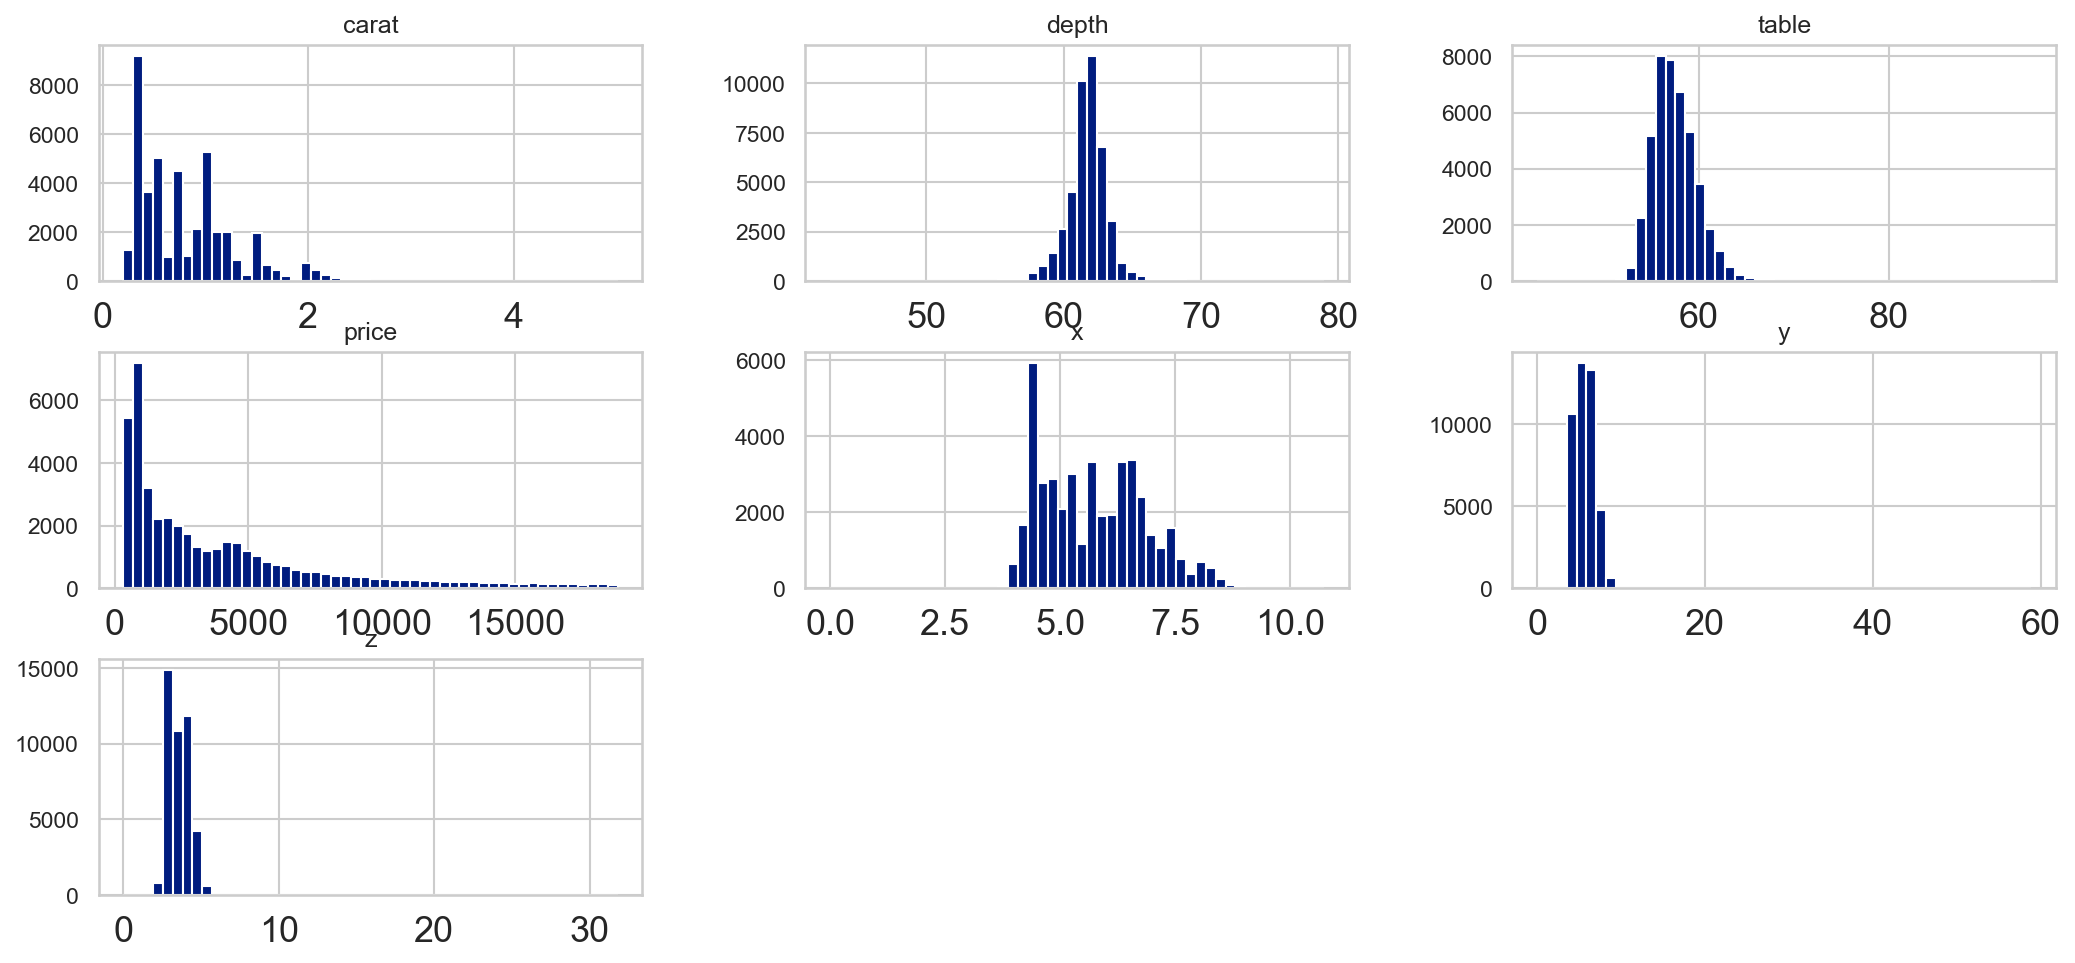

In [ ]:
df_diamonds.hist(bins=50)

**Visual Characteristics of the data**
1. The attributes price, carat, and table dept are having rightly skewed data
2. Most of the attibutes follows different distributions

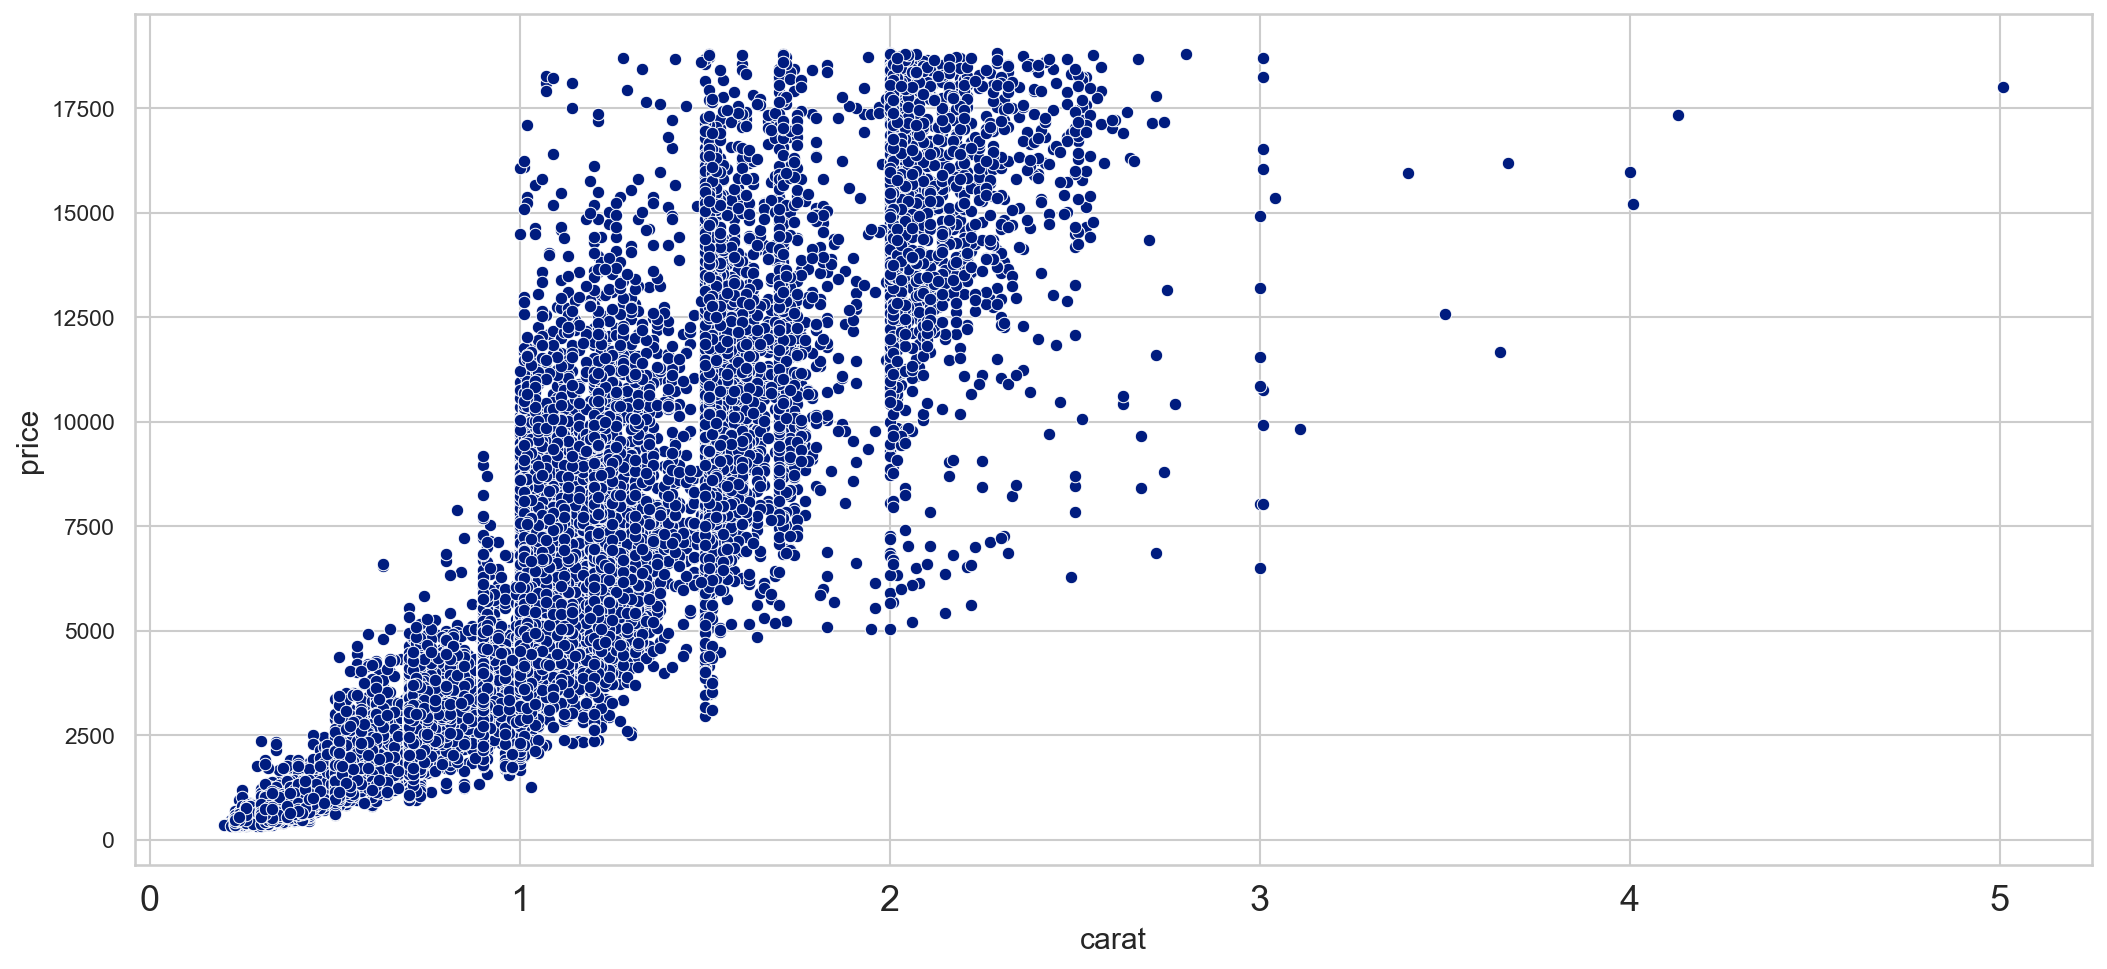

In [ ]:

sns.scatterplot(x='carat', y='price', data=df_diamonds)
plt.show()

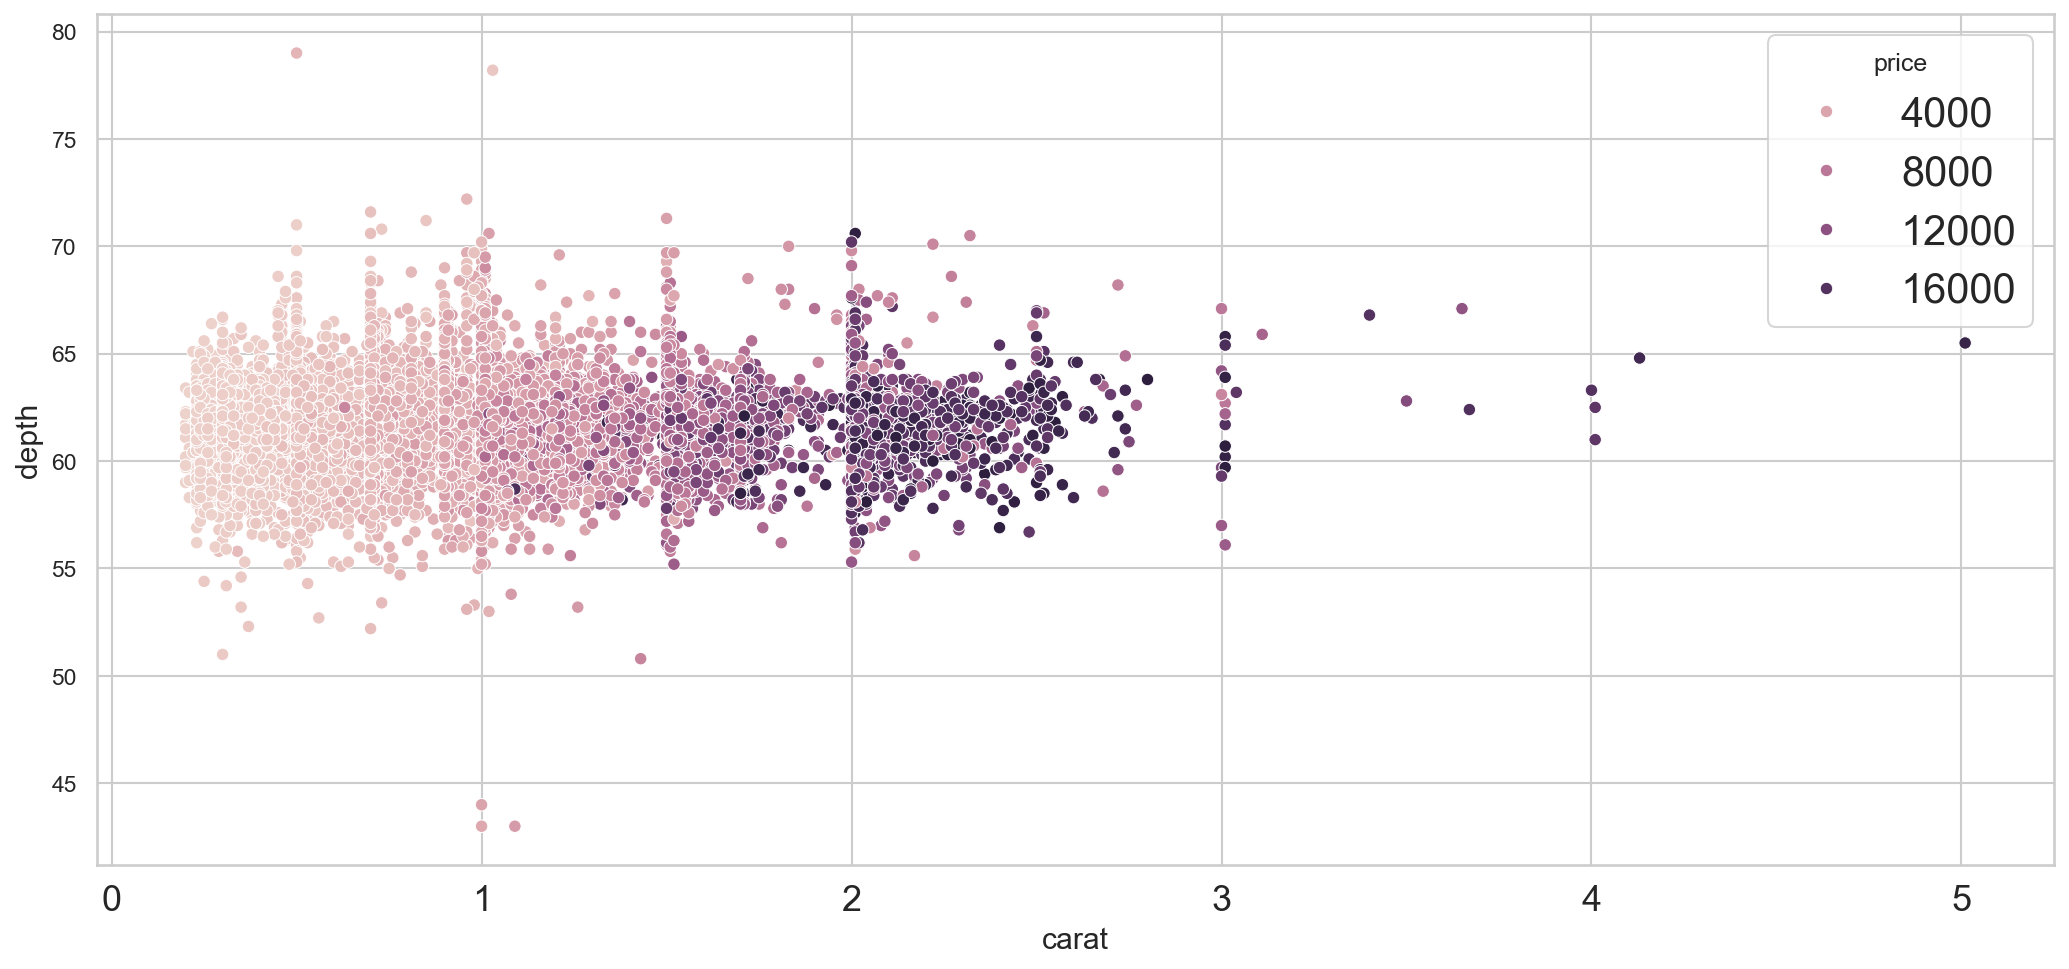

In [ ]:
sns.scatterplot(x='carat', y='depth', data=df_diamonds,hue='price')
plt.show()

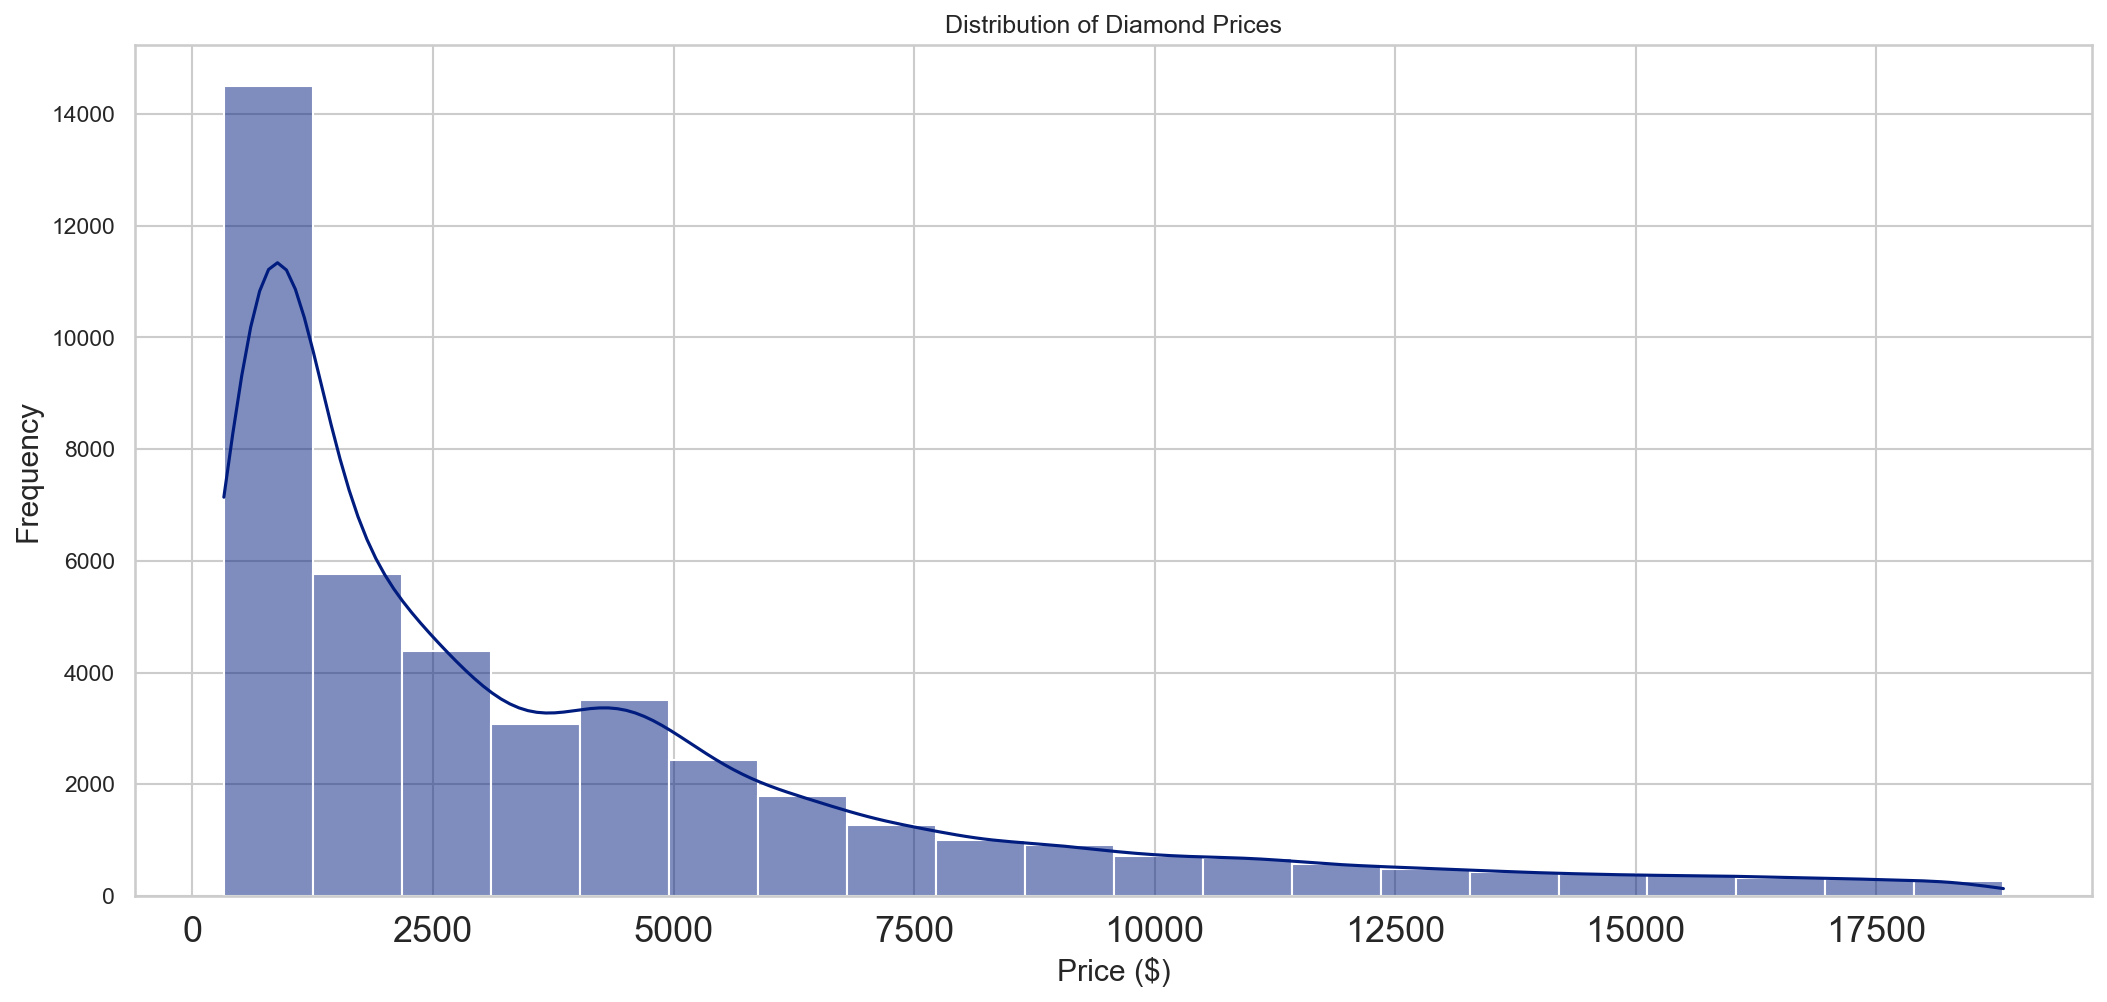

In [ ]:
sns.histplot(data=df_diamonds, x='price', bins=20, kde=True)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Diamond Prices')
plt.show()


### Checking and visualizing categorical data

In [41]:
# checking the values for each categorical variable
categorical_cols = ['cut','color','clarity']
for column in categorical_cols:
    print('Unique {} attributes:'.format(column))
    display(df_diamonds[column].unique().tolist())

Unique cut attributes:


['Ideal', 'Premium', 'Very Good', 'Fair', 'Good']

Unique color attributes:


['I', 'G', 'F', 'H', 'D', 'E', 'J']

Unique clarity attributes:


['SI2', 'VVS2', 'VS2', 'IF', 'VS1', 'SI1', 'VVS1', 'I1']

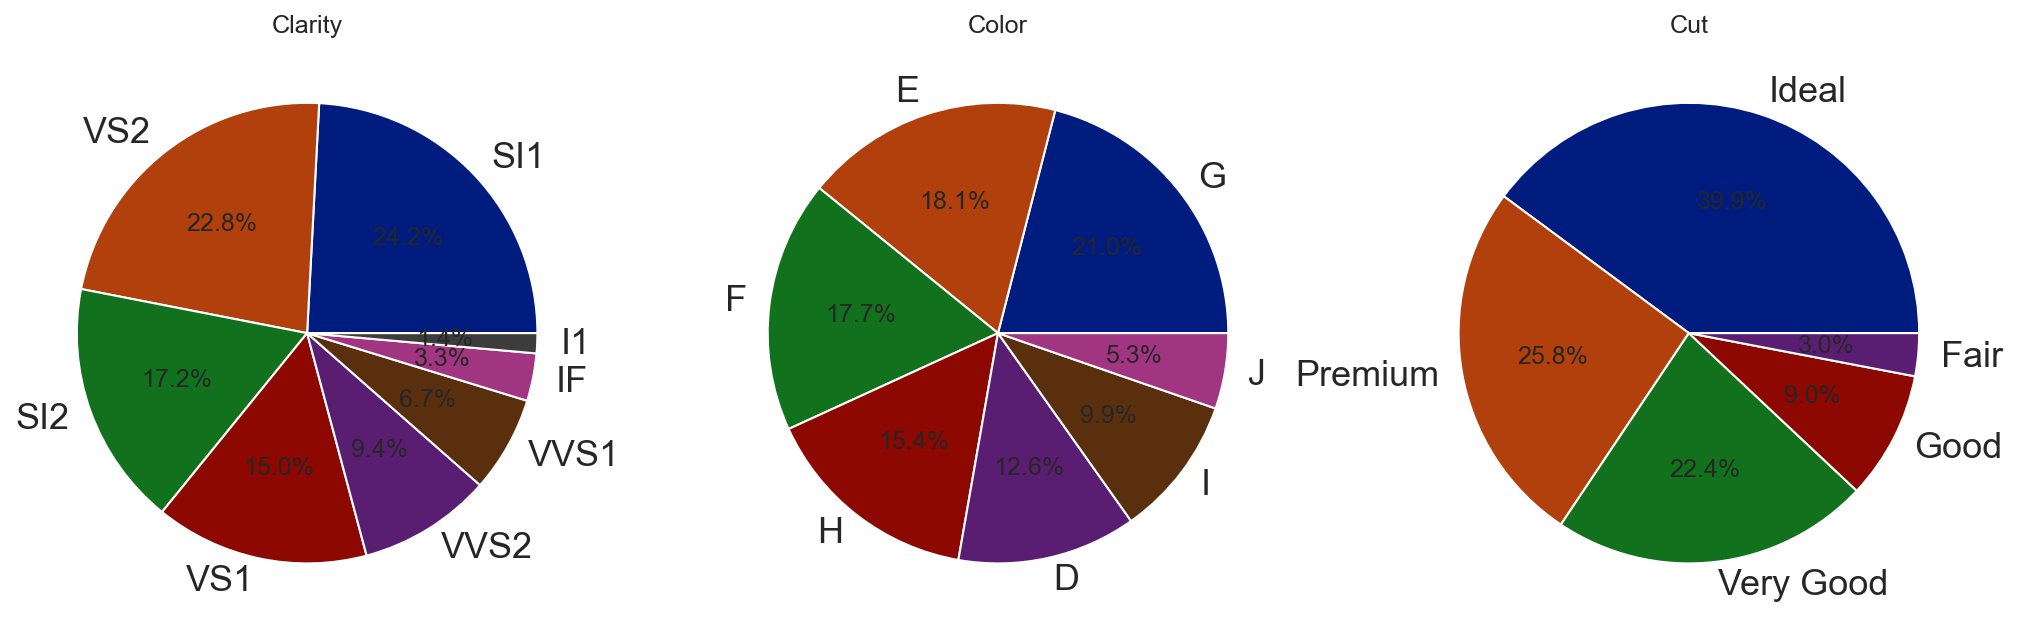

In [ ]:
clarity_stage = df_diamonds['clarity'].value_counts()
clarity_stage_name = clarity_stage.index
clarity_stage_value = clarity_stage.values

color_stage = df_diamonds['color'].value_counts()
color_stage_name = color_stage.index
color_stage_value = color_stage.values

cut_stage = df_diamonds['cut'].value_counts()
cut_stage_name = cut_stage.index
cut_stage_value = cut_stage.values

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].pie(clarity_stage_value, labels=clarity_stage_name, autopct='%1.1f%%')
ax[0].set_title('Clarity')

ax[1].pie(color_stage_value, labels=color_stage_name, autopct='%1.1f%%')
ax[1].set_title('Color')

ax[2].pie(cut_stage_value, labels=cut_stage_name, autopct='%1.1f%%')
ax[2].set_title('Cut')

plt.show()


**Visualizing relationships between categorical variables and target variable**

In [21]:
def draw_multiple_boxplots(cols) :
    for col in cols :
        plt.figure(figsize = (7,4))
        sns.boxplot(y = col , data = df_diamonds)
        plt.title(f'Box Plot of {col}')
        plt.ylabel(col)
        plt.show()

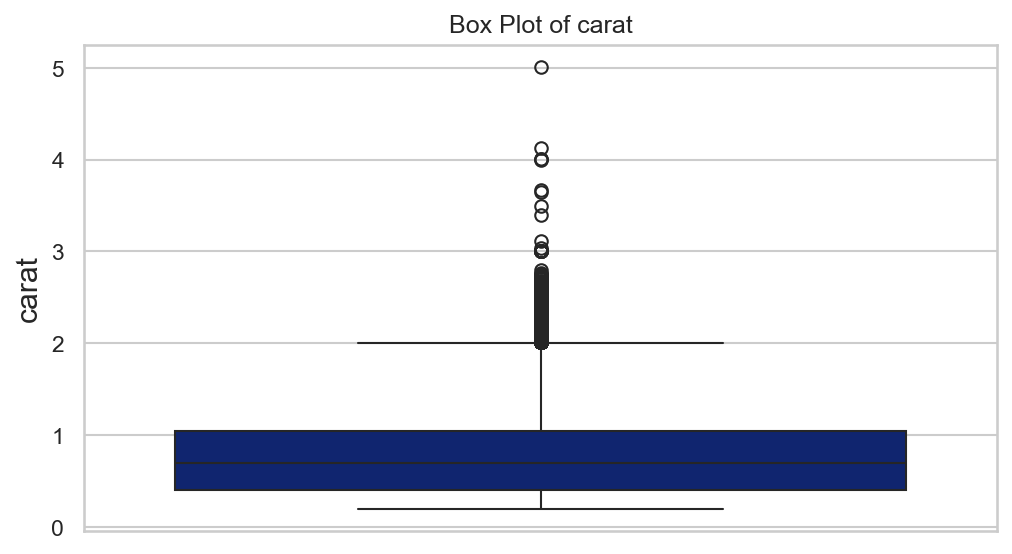

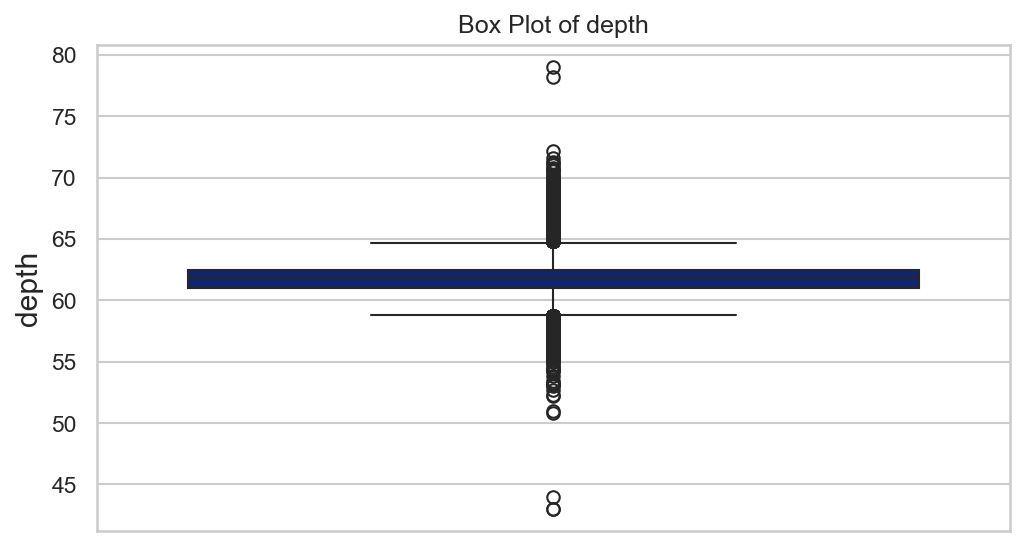

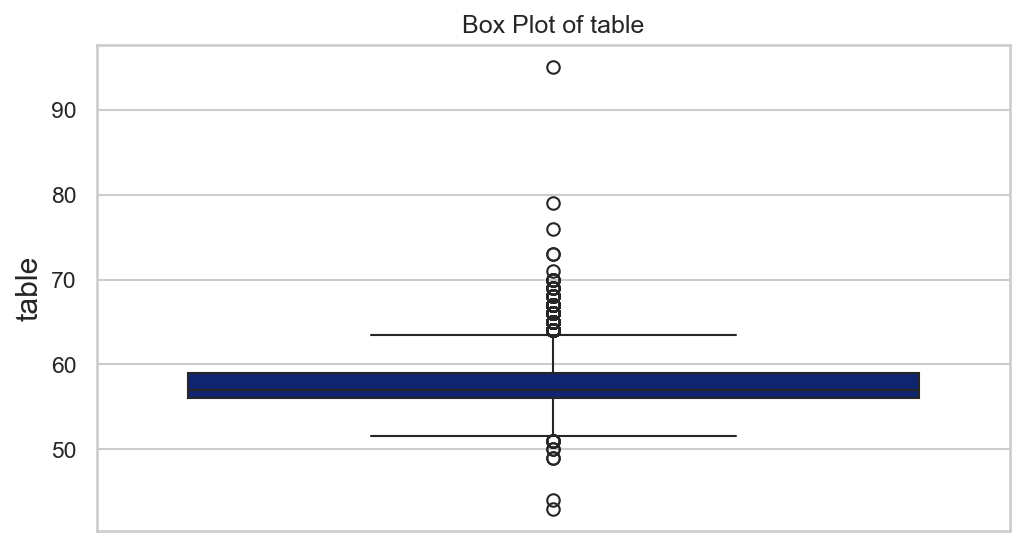

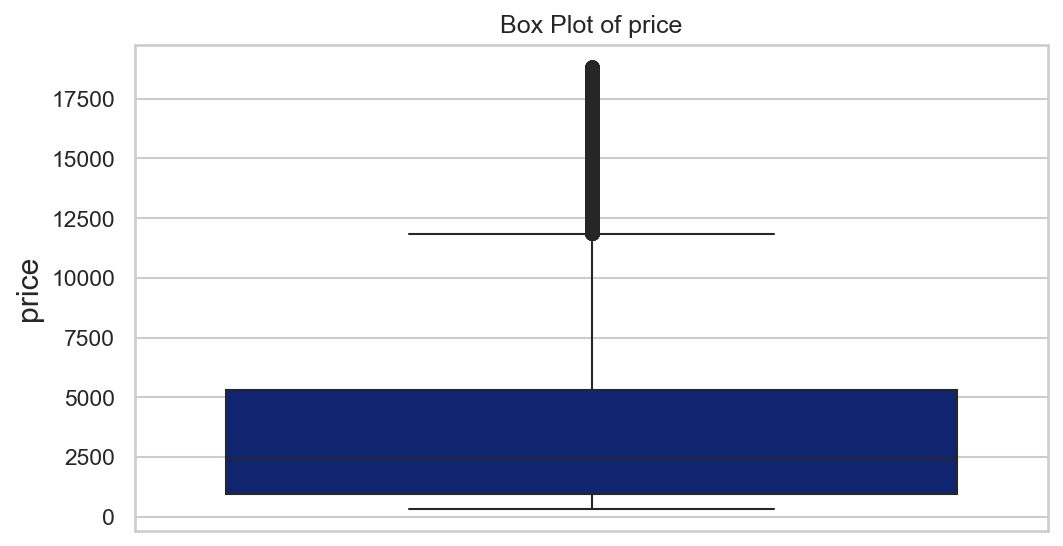

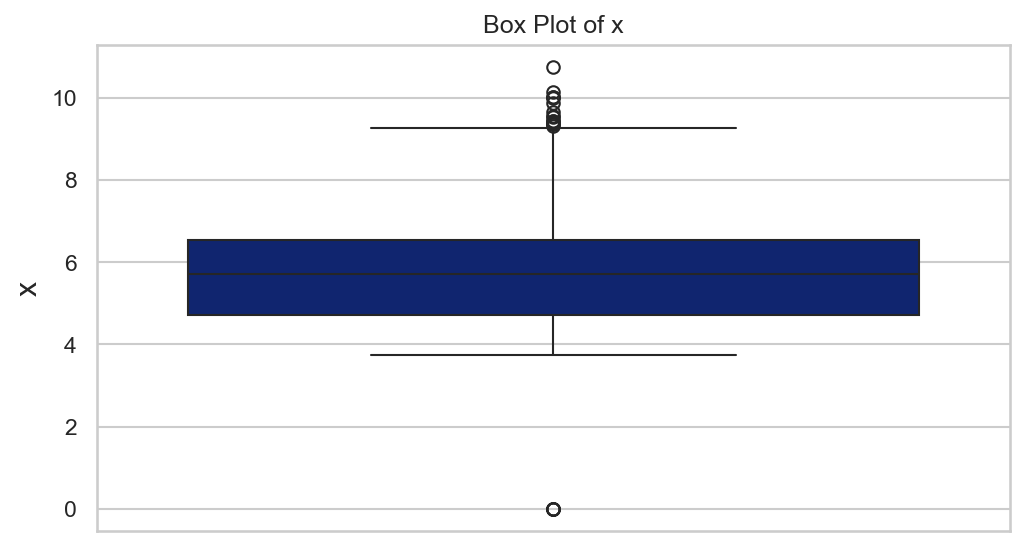

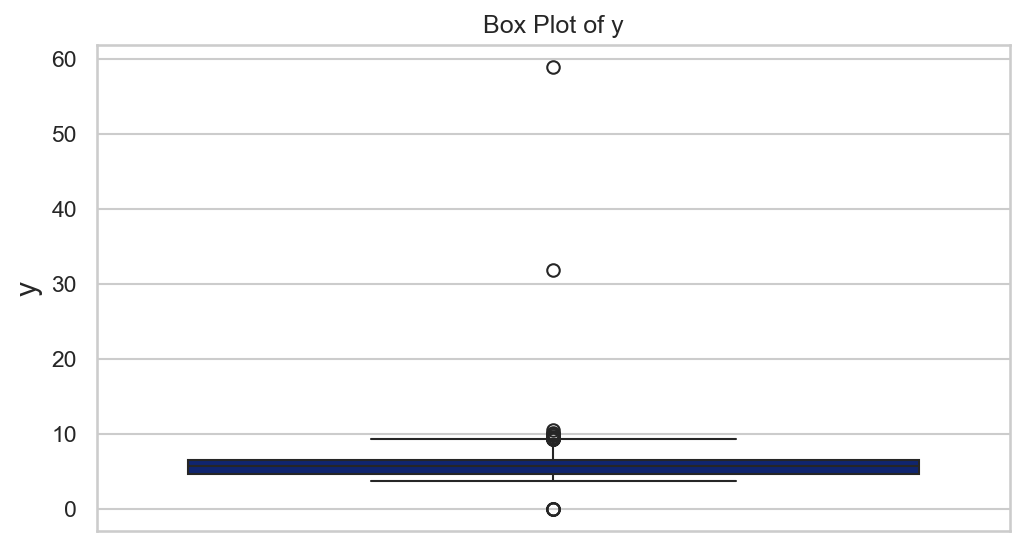

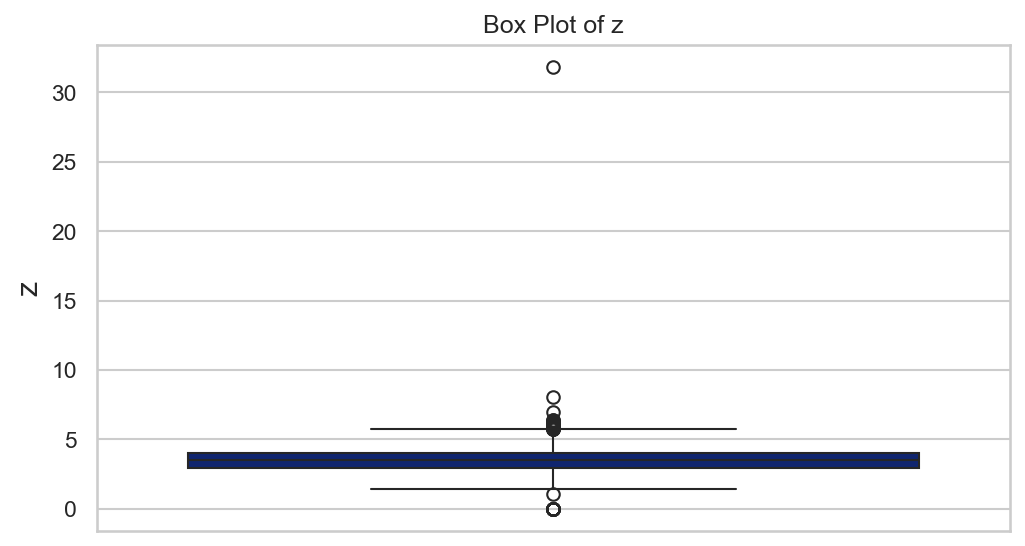

In [22]:
draw_multiple_boxplots(numeric_train_data)

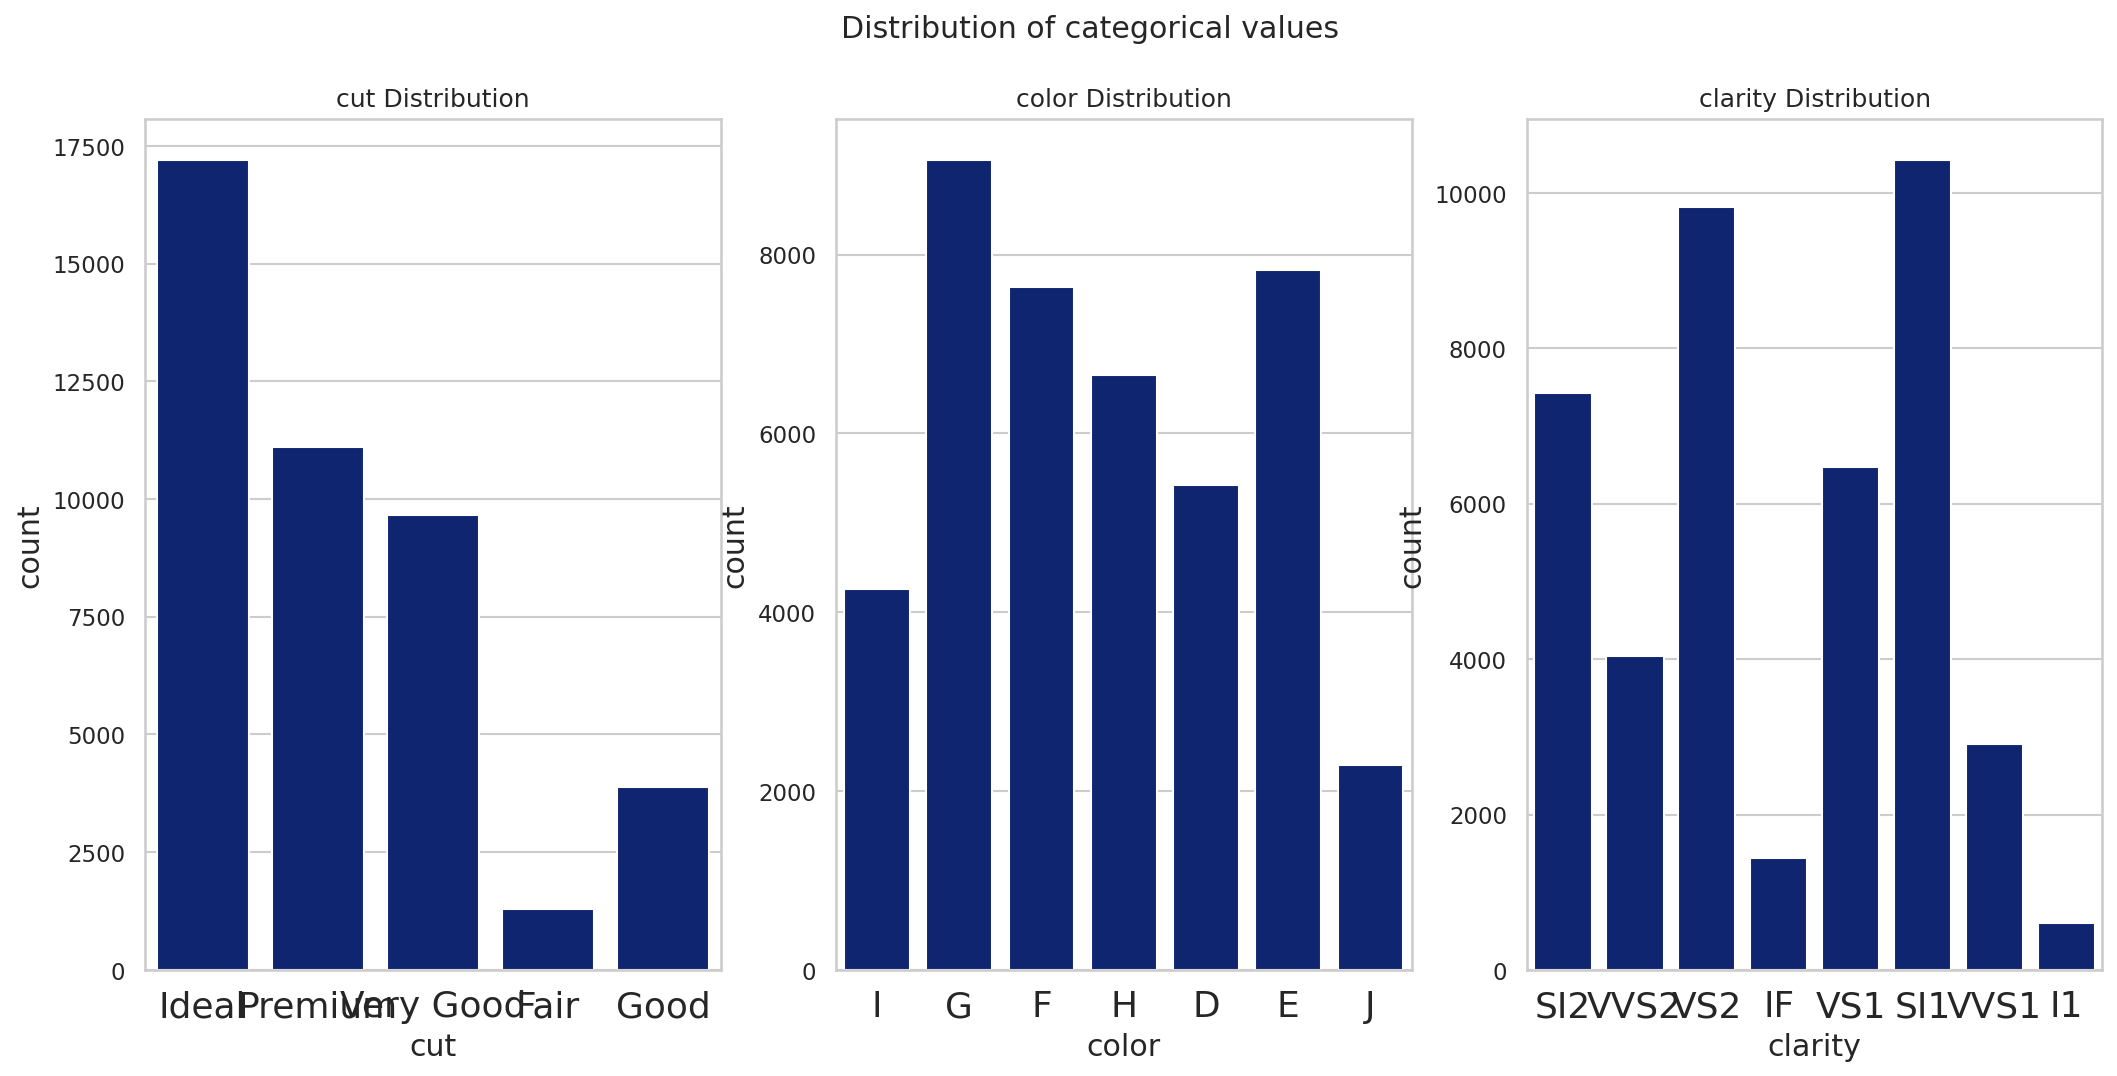

In [ ]:
fig,ax = plt.subplots(1,len(categorical_cols) , figsize=(15,7))
for i , column in enumerate(categorical_cols):

    sns.countplot(data = df_diamonds, x = column, ax=ax[i])
    ax[i].set_title(f'{column} Distribution')

fig.suptitle("Distribution of categorical values")
plt.show()

**From the barplots, it can be observed that even if the Cut quality(Best = Ideal, Worst = Fair), Clarity Quality(Best = IF, Worst = IF) and Color Quality(Best = D, Worst = J) increases respectively, the price and carat doesn't seems to be matching, one possible reason for this could be the saturation of the qualities of diamonds, hence we will try encoding these categorical variables and then try comparing.**

### Generating pairplot

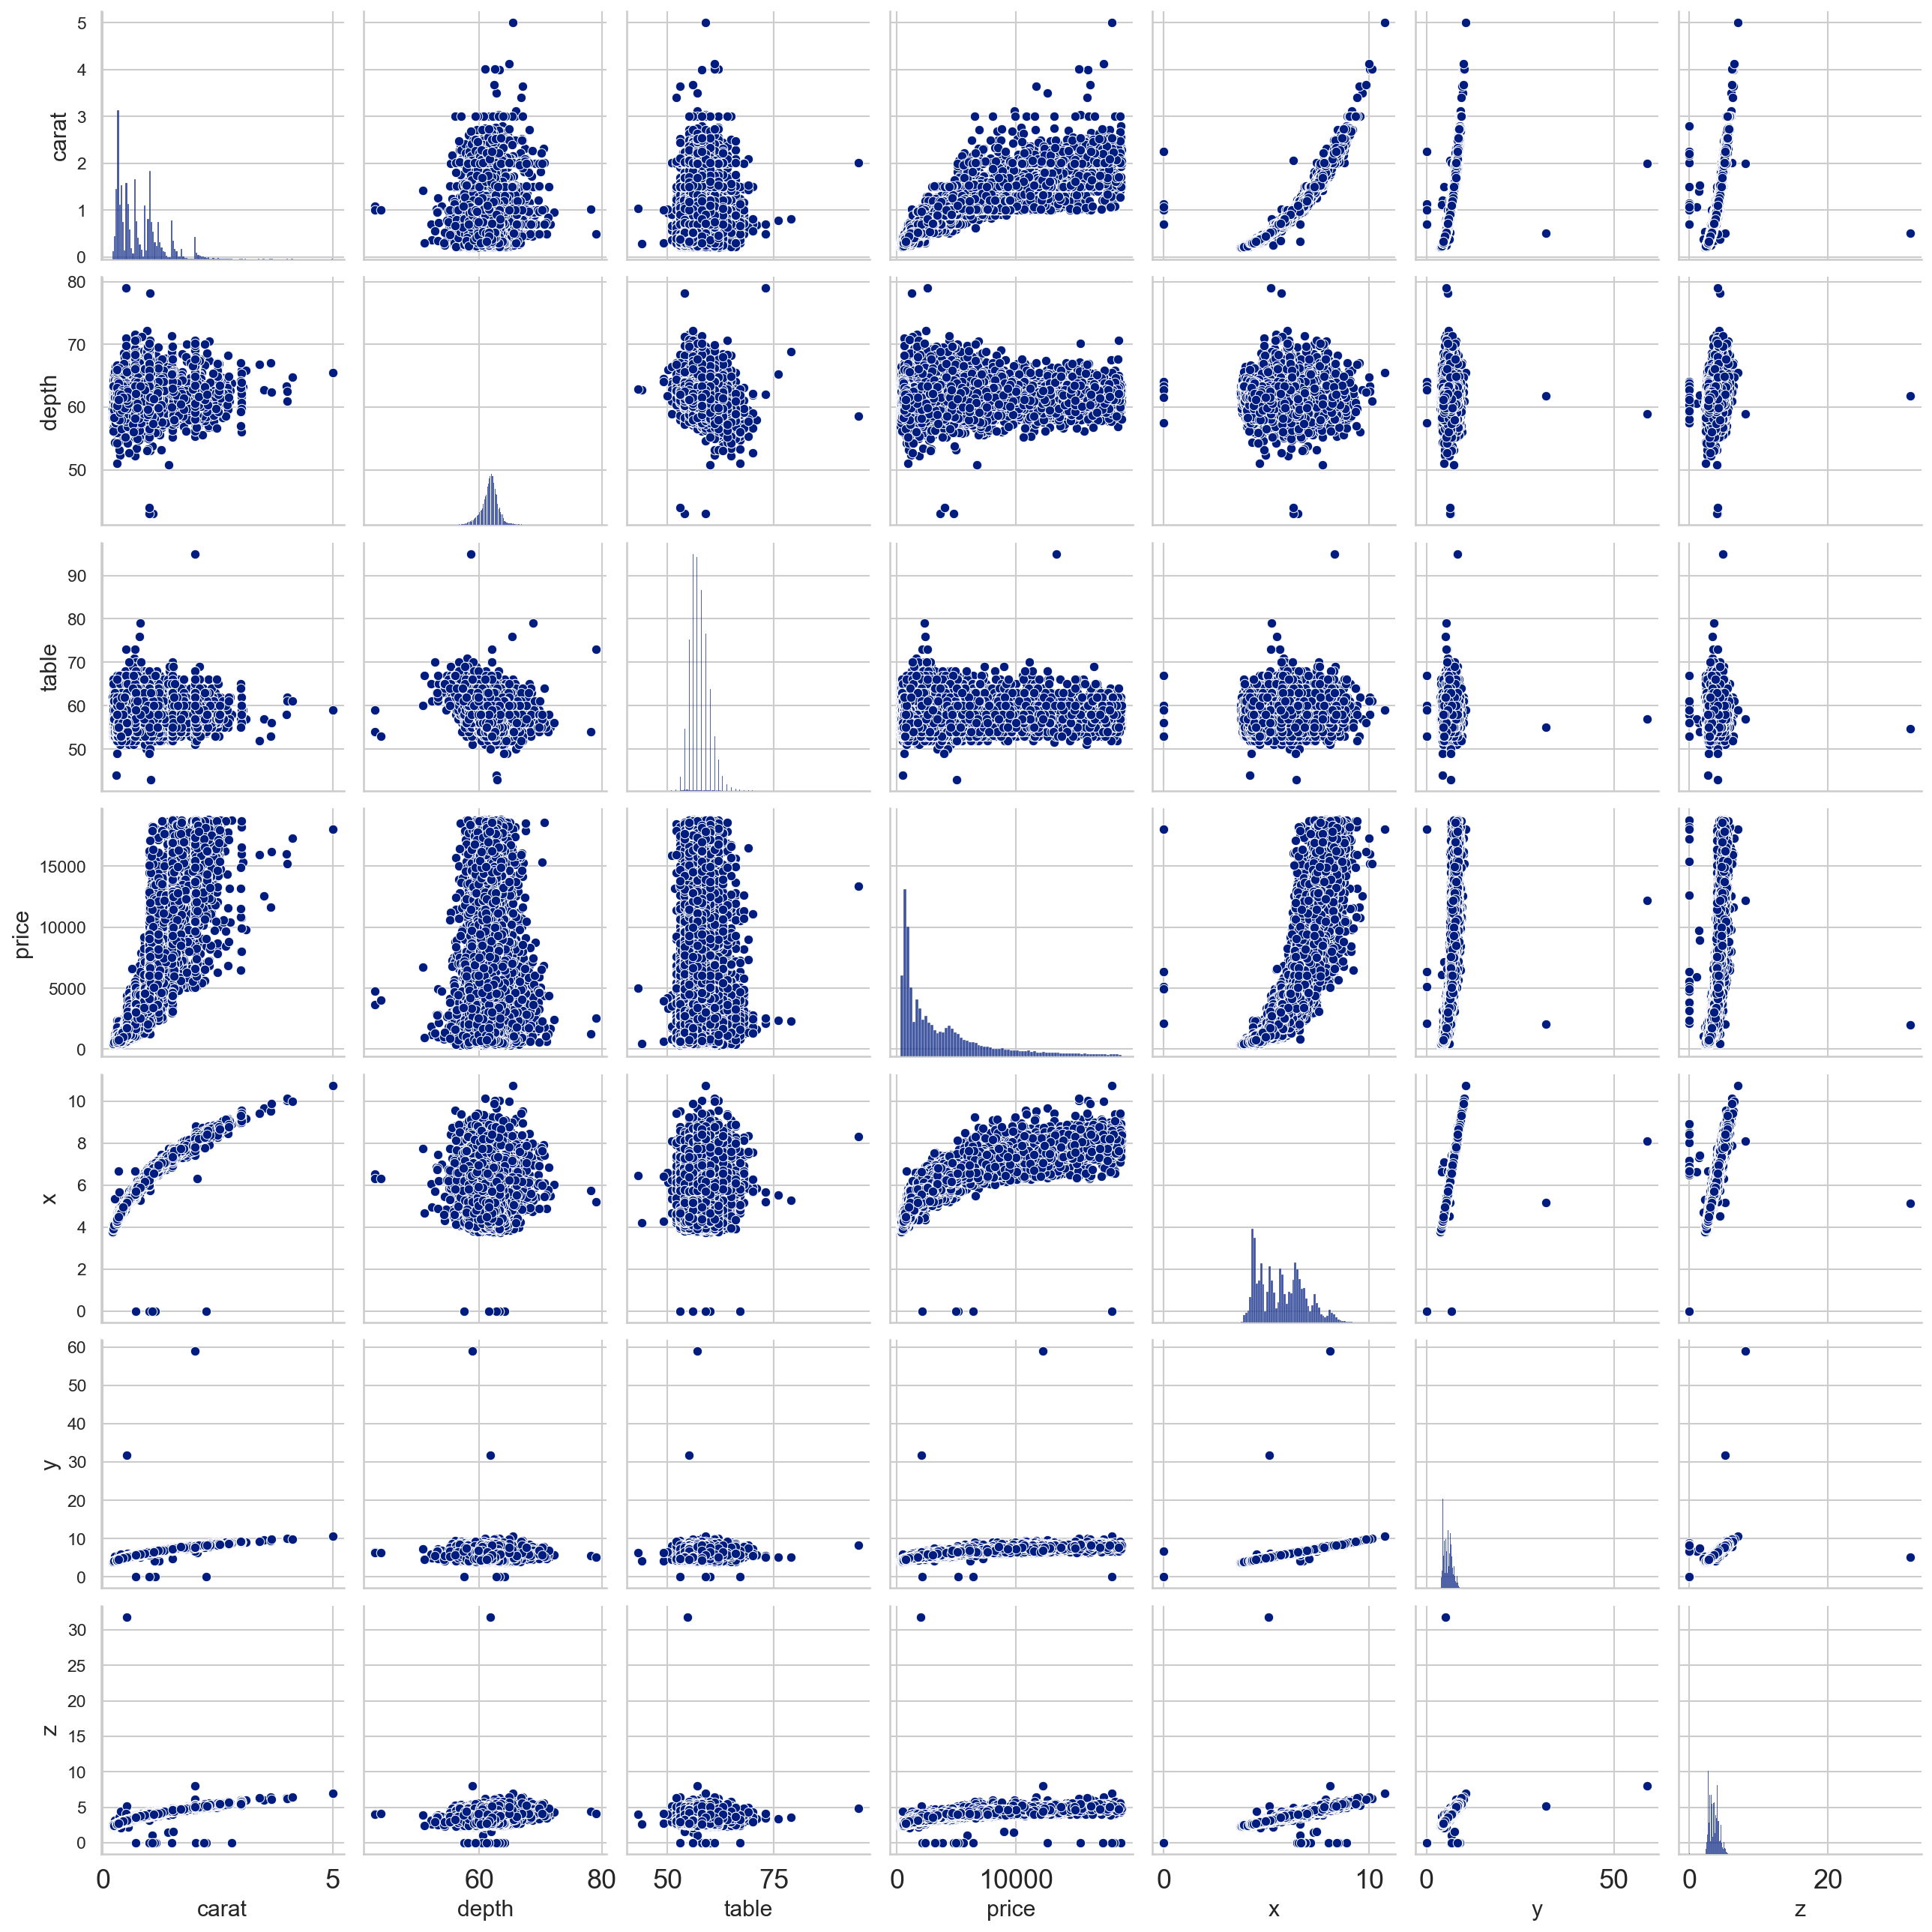

In [ ]:
# plotting pairplot of the data
sns.pairplot(df_diamonds)

**From the pairplot, following can be observed:**

1. There are certain feature variables which can be classified as outliers, because they seem to be far from the rest of the datapoints, which may play an important role in accuracy calculation of the model.
2. Some of the vaiables having datapoints far from rest of points are 'y', 'z', and going forward, a decision should be made whther or not to keep them, depending on the accuracy.

# Data Preprocessing

## Data Cleaning

### Delete Outliers

In [1]:
# def IQR(df_diamonds: pd.Series, whis: float = 1.5):
#     Q1, Q3 = np.quantile(df_diamonds, [0.25, 0.75])
#     IQR = Q3 - Q1
#     lower_boundary = Q1 - whis * IQR
#     upper_boundary = Q3 + whis * IQR
#     return (lower_boundary, upper_boundary)

# print("Outliers")
# def remove_IQR(df_diamonds):
#     for i in df_diamonds.select_dtypes(np.number):
#         print(f"{i}\t{(~df_diamonds[i].between(*IQR(df_diamonds[i]))).sum()/len(df_diamonds)*100:0.2f}%")
#         df_diamonds = df_diamonds[df_diamonds[i].between(*IQR(df_diamonds[i]))]
#     return df_diamonds
# df_diamonds= remove_IQR(df_diamonds)

In [86]:
def func_z(row):
    if row["z"] == 0:
        return np.round((row["depth"] * ((row["y"] + row["x"]) / 2) / 100), 2)
    return row["z"]

# إزالة الصفوف حيث تكون القيم غير منطقية
df_diamonds = df_diamonds[~((df_diamonds["z"] == 0) & (df_diamonds["x"] == 0))]

# تطبيق الدالة على كل صف
df_diamonds["z"] = df_diamonds.apply(func_z, axis=1)


In [81]:
df_diamonds = df_diamonds[(df_diamonds["depth"] < 75) & (df_diamonds["depth"] > 45)]
df_diamonds = df_diamonds[(df_diamonds["table"] < 80) & (df_diamonds["table"] > 40)]
df_diamonds = df_diamonds[(df_diamonds["x"]<15)]
df_diamonds = df_diamonds[(df_diamonds["y"]<15)]
df_diamonds = df_diamonds[(df_diamonds["z"]<15)&(df_diamonds["z"]>2)]
df_diamonds = df_diamonds[(df_diamonds["price"] > 9500)]

## Handling categorical variables

In [87]:
clarity_map = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
df_diamonds["clarity"]= df_diamonds["clarity"].map(clarity_map)

cut_map= {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
df_diamonds["cut"]= df_diamonds["cut"].map(cut_map)

color_map= {"J":1,"I":2,"H":3,"G":4,"F":5,"E":6,"D":7}
df_diamonds["color"]= df_diamonds["color"].map(color_map)

## Feature Engineering

In [23]:
df_diamonds["y_log"] = np.log10(df_diamonds["y"]+1)
df_diamonds["z_log"] = np.log10(df_diamonds["z"]+1)

here we create new feature "volume" from x,y,z

In [24]:

df_diamonds["volume"]=df_diamonds["x"] * df_diamonds["y"] * df_diamonds["z"]
df_diamonds.drop(["x","y","z"],axis=1,inplace=True)


## Feature Scalling

In [91]:
X = df_diamonds.drop("price",axis=1)
y = df_diamonds["price"]
X_continous = X.drop(["cut","color","clarity"],axis=1)
X_discrit = X[["cut","color","clarity"]]

In [93]:
sscaler = StandardScaler()
pf = PolynomialFeatures(degree=3)
X_Sc= sscaler.fit_transform((pf.fit_transform(X_continous)))
X = np.concatenate((X_Sc,X_discrit),axis=1)
# feature scaling using Standard Scaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)


**Split Data**

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,)


# Select and Train a Model

In [ ]:
# chossing the regression models
regression_models = ['Linear Regression', 'Lasso Regression',  'Ridge Regression', 'DecisionTree Regression', 'RandomForest Regression']

regressors = []

regressors.append(LinearRegression())
regressors.append(Lasso(alpha=0.0001))
regressors.append(Ridge())
regressors.append(DecisionTreeRegressor())
regressors.append(RandomForestRegressor())

In [ ]:
# creating lists to keep track of the training and the testing R2 Scores
train_r2_scores = []
test_r2_scores = []

# training and testing all the regression models
for regressor in regressors:
    regression_pipeline = Pipeline(steps = [
              ('regressor',regressor)
           ])

    print(f'************START OF THE {regressor} MODEL************')

    # print(f'Training the {regressor} model')
    start_time = time.time()
    model = regression_pipeline.fit(X_train, y_train)
    end_time = time.time()
    print(f'Time taken to fit the {regressor} model: {round(end_time - start_time, 2)} seconds')

    train_predictions = model.predict(X_train)
    train_rmse = mean_squared_error(y_train, train_predictions)**0.5
    train_r2 = r2_score(y_train, train_predictions)
    train_r2_scores.append(train_r2)
    print(f'Training Details: RMSE= {train_rmse},  R2 score= {train_r2}')

    # print(f'\nTesting the {regressor} model')

    test_predictions = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, test_predictions)**0.5
    test_r2 = r2_score(y_test, test_predictions)
    test_r2_scores.append(test_r2)
    print(f'Testing Details:  RMSE= {test_rmse}, R2 score= {test_r2}')

    print(f'************END OF THE {regressor} MODEL************\n')

************START OF THE LinearRegression() MODEL************
Time taken to fit the LinearRegression() model: 0.03 seconds
Training Details: RMSE= 1227.2595003801127,  R2 score= 0.9051735226712376
Testing Details: RMSE= 1192.93186914674, R2 score= 0.9098849992853519
************END OF THE LinearRegression() MODEL************

************START OF THE Lasso(alpha=0.0001) MODEL************
Time taken to fit the Lasso(alpha=0.0001) model: 4.83 seconds
Training Details: RMSE= 1227.7073121049768,  R2 score= 0.9051043080418468
Testing Details: RMSE= 1193.056069736309, R2 score= 0.9098662338903697
************END OF THE Lasso(alpha=0.0001) MODEL************

************START OF THE Ridge() MODEL************
Time taken to fit the Ridge() model: 0.01 seconds
Training Details: RMSE= 1227.259870590339,  R2 score= 0.905173465461272
Testing Details: RMSE= 1192.9409824874365, R2 score= 0.9098836224224118
************END OF THE Ridge() MODEL************

************START OF THE DecisionTreeRegresso

### Model Evaluation

In [ ]:
# comparing the training and the testing R2 Scores of all the models
model_r2_compare = pd.DataFrame({'Algorithm' : regression_models, 'Training_R2_Score' : train_r2_scores, 'Testing_R2_Score' : test_r2_scores})
model_r2_compare.sort_values(by='Testing_R2_Score', ascending=False)

,Algorithm,Training_R2_Score,Testing_R2_Score
4,RandomForest Regression,0.997314,0.980521
3,DecisionTree Regression,1.000000,0.963040
0,Linear Regression,0.905182,0.909879
2,Ridge Regression,0.905182,0.909878
1,Lasso Regression,0.905113,0.909860


[Text(0, 0, 'Linear Regression'),
 Text(1, 0, 'Lasso Regression'),
 Text(2, 0, 'Ridge Regression'),
 Text(3, 0, 'DecisionTree Regression'),
 Text(4, 0, 'RandomForest Regression')]

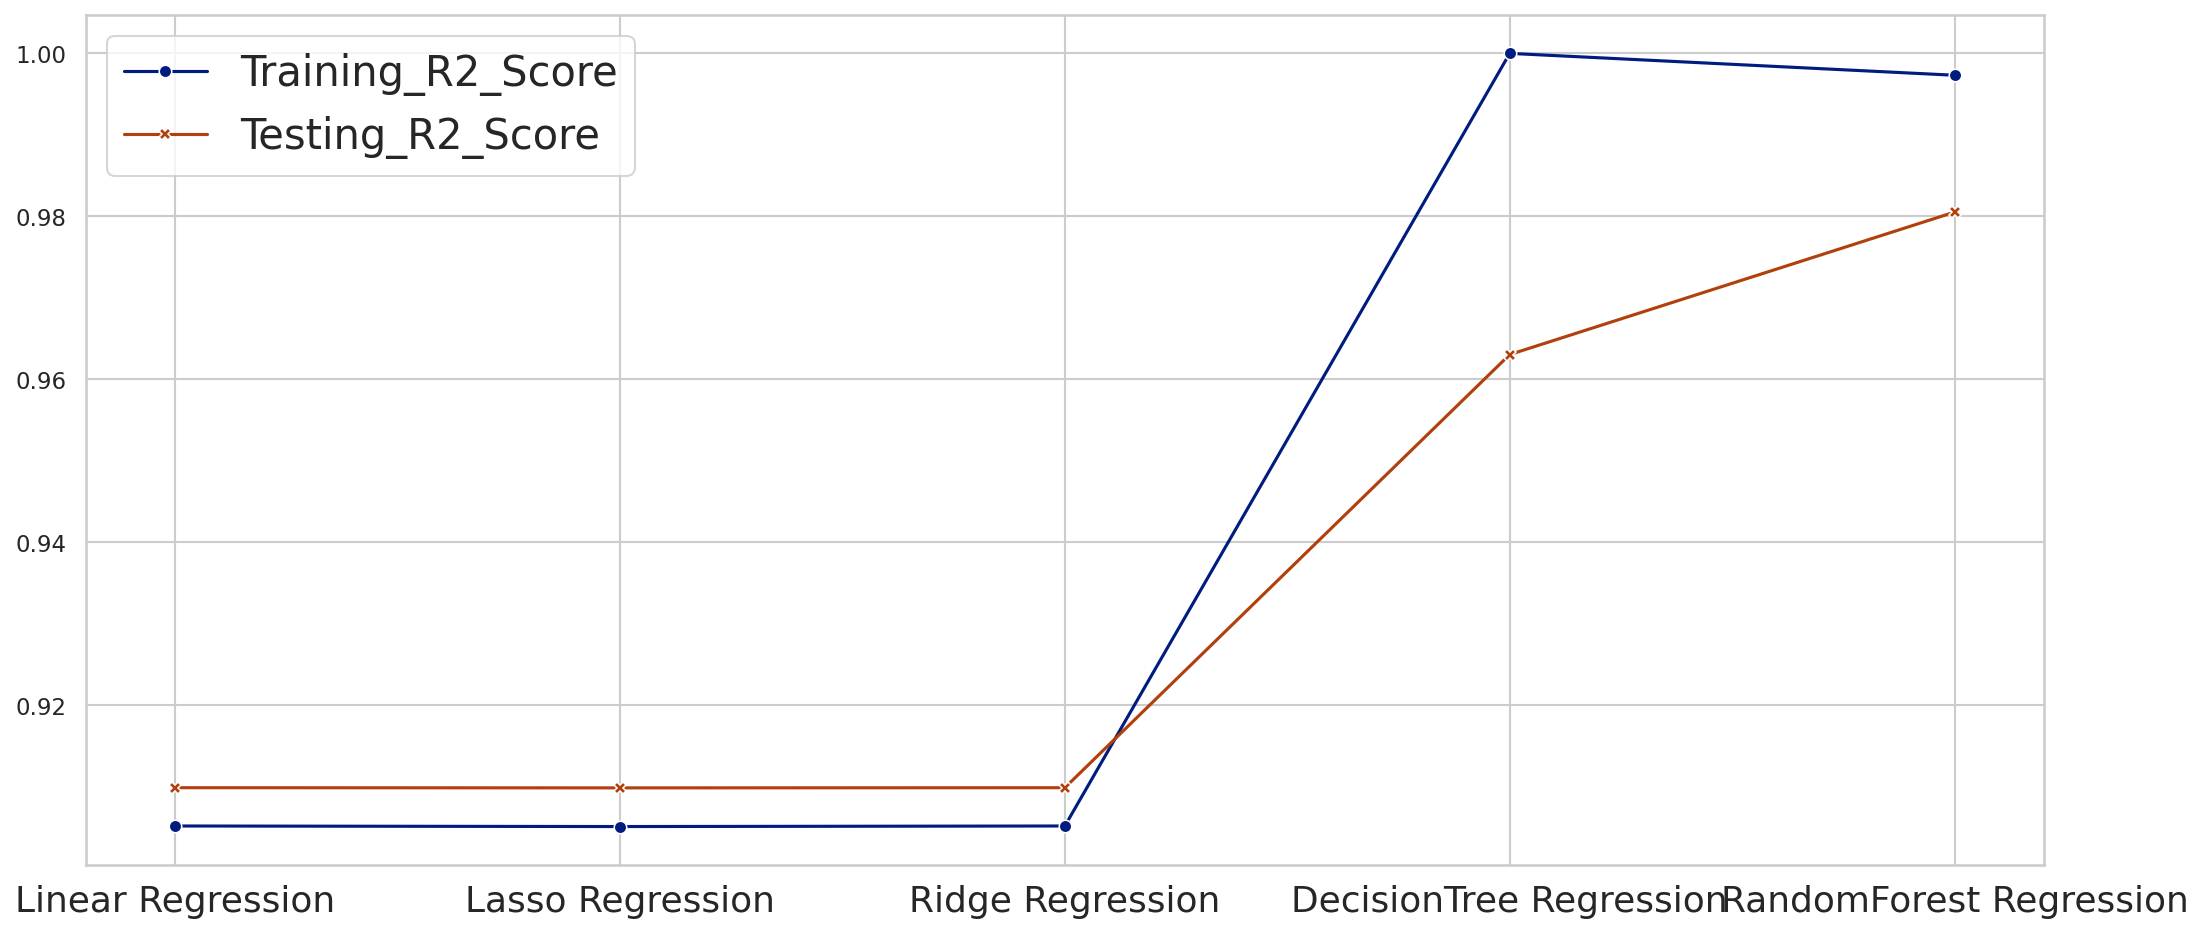

In [ ]:
# visualizing the training and the testing R2 Scores of all the models
ax = sns.lineplot(data=[model_r2_compare['Training_R2_Score'], model_r2_compare['Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(model_r2_compare['Algorithm'])))
ax.set_xticklabels(model_r2_compare['Algorithm'])

 **Analysis of the Regression Models**



R2 Score is leveraged to evaluate the performance of the various regression models. All the regression models with default parameters are tried and the following is observed:
- R2 Score standings based on the training data is as follows:
  1. DecisionTree Regression
  2. RandomForest Regression
  3. Ridge Regression and Lasso Regression
  4. Linear Regression
- R2 Score standings based on the testing data is as follows:
  1. RandomForest Regression
  2. DecisionTree Regression
  3. Ridge Regression
  4. Lasso Regression
  5. Linear Regression
- The baseline Multivariate Linear Regression model is the least performant model as it just explains 90.34% (R2 Score) of the variability in the price and the carat of the diamond as compared to all the other models.
- The testing R2 score of the baseline Multivariate Linear Regression model, Ridge Regression model, and the Lasso Regression model are very close. This suggests that using regularization has almost no improvement over the baseline model.
- The DecisionTree Regression and the RandomForest Regression with a testing R2 score of 97.90% and 98.91%, respectively outperform the baseline Multivariate Linear Regression model, Ridge Regression model, and the Lasso Regression model by a significant margin.
- Even though the R2 Score of the DecisionTree Regressor on the training data is the highest, the RandomForest Regressor outperforms it on the testing data.
- This suggests that the RandomForest Regression model is the best model as it is able to better explain the variability in the price and carat of the diamond as compared to all the other models.

## Hyperparameter Tuning

Following are the most important settings for a RandomForest Regressor:
1. **n_estimators**: number of trees in the forest
2. **max_features**: maximum number of features considered for splitting a node

The above hyperparameters are tuned along with another hyperparameter named **bootstrap** that tells if the data points are sampled with or without replacement.





### **First Grid Search with Cross Validation**

In [ ]:
# storing the testing data R2 Score of the base RandomForest Regressor model
rf_base_r2 = max(model_r2_compare.sort_values(by='Testing_R2_Score', ascending=False)['Testing_R2_Score'])

In [ ]:
# initializing a list to store improvement in R2 Score using Grid Search with Cross Validation
improved_test_r2_scores = [rf_base_r2]

# initializing a list to track the run time of the improvement models that follow
run_time = []

In [ ]:
# initializing a RandomForest Regressor with the best parameters obtained from first grid search
random_forest_regressor = RandomForestRegressor(bootstrap=True, n_estimators=150)

# training and testing the model along with tracking the run time
print(f'Training the {random_forest_regressor} model')

start_time = time.time()
model = random_forest_regressor.fit(X_train, y_train)

print(f'\nTesting the {random_forest_regressor} model')

grid_one_test_predictions = model.predict(X_test)
end_time = time.time()
current_run_time = round(end_time - start_time, 2)
print(f'Time taken to fit and test the {random_forest_regressor} model: {current_run_time} seconds')
# run_time.append(current_run_time)

grid_one_rmse = mean_squared_error(y_test, grid_one_test_predictions)**0.5
grid_one_r2 = r2_score(y_test, grid_one_test_predictions)
# improved_test_r2_scores.append(grid_one_r2)
print('\nTesting Details:')
print(f'{random_forest_regressor} model RMSE: {grid_one_rmse}')
print(f'{random_forest_regressor} model R2 score: {grid_one_r2}')

Training the RandomForestRegressor(n_estimators=150) model

Testing the RandomForestRegressor(n_estimators=150) model
Time taken to fit and test the RandomForestRegressor(n_estimators=150) model: 28.23 seconds

Testing Details:
RandomForestRegressor(n_estimators=150) model RMSE: 551.7046946044202
RandomForestRegressor(n_estimators=150) model R2 score: 0.9807256754448156


In [ ]:
# viewing the improvement in the R2 Score over the base R2 Score
print(f'Improvement of {((grid_one_r2 - rf_base_r2) / rf_base_r2)}')

Improvement of 0.00020884714536686607


### **Second Grid Search with Cross Validation**

In [ ]:
# intializing the list using the base and the improved RandomForest Regression models
improved_reg_models = ['RandomForestRegression', 'RandomForestRegression_GridSearchOne']

In [ ]:
### it has bad score than the above  ###

#  initializing a RandomForest Regressor
forest_reg = RandomForestRegressor()

# initializing the second grid search
#grid_search_two = GridSearchCV(forest_reg, param_grid_two, cv=5, scoring='r2', return_train_score=True)

# initializing a RandomForest Regressor with the best parameters obtained from second grid search
random_forest_regressor = RandomForestRegressor(bootstrap=True, max_features=22, n_estimators=275)

# training and testing the model along with tracking the run time
print(f'Training the {random_forest_regressor} model')

start_time = time.time()
model = random_forest_regressor.fit(X_train, y_train)

print(f'\nTesting the {random_forest_regressor} model')

grid_two_test_predictions = model.predict(X_test)
end_time = time.time()
current_run_time = round(end_time - start_time, 2)
print(f'Time taken to fit and test the {random_forest_regressor} model: {current_run_time} seconds')
# run_time.append(current_run_time)

grid_two_rmse = mean_squared_error(y_test, grid_two_test_predictions)**0.5
grid_two_r2 = r2_score(y_test, grid_two_test_predictions)
# improved_test_r2_scores.append(grid_two_r2)
print('\nTesting Details:')
print(f'{random_forest_regressor} model RMSE: {grid_two_rmse}')
print(f'{random_forest_regressor} model R2 score: {grid_two_r2}')

Training the RandomForestRegressor(max_features=22, n_estimators=275) model

Testing the RandomForestRegressor(max_features=22, n_estimators=275) model
Time taken to fit and test the RandomForestRegressor(max_features=22, n_estimators=275) model: 51.48 seconds

Testing Details:
RandomForestRegressor(max_features=22, n_estimators=275) model RMSE: 551.1583520552109
RandomForestRegressor(max_features=22, n_estimators=275) model R2 score: 0.9807638305292168


### XGB

In [95]:
xgb_reg = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 7, n_estimators= 200, subsample= 0.9)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [96]:
xgb_reg_test_predictions = xgb_reg.predict(X_test)

xgb_reg_rmse = mean_squared_error(y_test, xgb_reg_test_predictions)**0.5
xgb_reg_r2 = r2_score(y_test, xgb_reg_test_predictions)
print('\nTesting Details:')
print(f' model RMSE: {xgb_reg_rmse}')
print(f' model R2 score: {xgb_reg_r2}')


Testing Details:
 model RMSE: 304.0073572000565
 model R2 score: 0.9827128818822223


In [97]:
# Define the XGBRegressor model
xgb_reg = xgb.XGBRegressor()

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [100,200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],            # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.3], # Step size shrinkage
    'subsample': [0.7, 0.8, 0.9],      # Subsample ratio of training instances
    'colsample_bytree': [0.7, 0.8, 0.9],# Subsample ratio of columns

}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train) # Assuming X_train and y_train are your training data

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Negative MSE):", best_score)
print("Best RMSE:", np.sqrt(-best_score))


Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Score (Negative MSE): -90738.25684638887
Best RMSE: 301.22791511808606


In [98]:
final_model = grid_search.best_estimator_

### AdaBoost

In [100]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators = 100)
ada_reg.fit(X_train,y_train)
ada_reg_test_predictions = ada_reg.predict(X_test)

ada_reg_rmse = mean_squared_error(y_test,ada_reg_test_predictions)**0.5
ada_reg_r2 = r2_score(y_test, ada_reg_test_predictions)
print('\nTesting Details:')
print(f' model RMSE: {ada_reg_rmse}')
print(f' model R2 score: {ada_reg_r2}')

# befor PolynomialFeatures Details:
#  model RMSE: 1136.374353860601
#  model R2 score: 0.918227239999336


Testing Details:
 model RMSE: 638.3953683415202
 model R2 score: 0.9237686051443924


# Submitting

In [120]:
test_data= pd.read_csv("test.csv")
test_data.shape

(10788, 10)

In [121]:
ids = test_data["Id"]

In [122]:
test_data["y_log"] = np.log10(test_data["y"]+1)
test_data["z_log"] = np.log10(test_data["z"]+1)

test_data["volume"]=test_data["x"] * test_data["y"] * test_data["z"]
test_data.drop(["x","y","z","Id"],axis=1,inplace=True)


In [123]:
clarity_map = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
test_data["clarity"]= test_data["clarity"].map(clarity_map)

cut_map= {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
test_data["cut"]= test_data["cut"].map(cut_map)

color_map= {"J":1,"I":2,"H":3,"G":4,"F":5,"E":6,"D":7}
test_data["color"]= test_data["color"].map(color_map)

X_test_without_id_cont = test_data.drop(["cut","color","clarity"],axis=1)
X_test_without_id_dist = test_data[["cut","color","clarity"]]

In [124]:
scaled =sscaler.transform(pf.transform(X_test_without_id_cont))
scaled = np.concatenate((scaled,X_test_without_id_dist),axis=1)
# test_data_norm= sc.transform(test_data)

In [ ]:
final_predictions = final_model.predict(scaled)
data={'Id':ids,'Price':final_predictions }

sub=pd.DataFrame(data)
sub.to_csv('sub.csv', index=False)
sub.shape


(10788, 2)